In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.cuda import amp
import torchaudio
import numpy as np
from functools import partial
from scipy.signal.windows import boxcar
import kazane
import matplotlib.pyplot as plt
from torch_fftconv import fft_conv1d
from models import UnconditionalDiffWave, CosineScheduler, NoiseScheduler, NuWave
from utils.utils import gamma2logas, beta2gamma, gamma2as
import librosa
import librosa.display as display
from tqdm import tqdm
import IPython.display as ipd
from pathlib import Path

device = torch.device('cuda:0')

# Hyper Parameters

In [2]:
q = 2
roll_off = 0.962
num_zeros = 128
n_fft = 4096
hop_length = 512
window_func = partial(torch.kaiser_window, periodic=False,
                      beta=14.769656459379492)

checkpoint = 'saved/training_checkpoint_600000.pt'
nuwave_checkpoint = '/home/ycy/data-disk/DeepLearning/nuwave/checkpoints/checkpoints_nuwave_x3/nuwave_x3_01_10_23_epoch=653_EMA'
# nuwave_checkpoint = '/home/ycy/data-disk/DeepLearning/nuwave/checkpoints/checkpoints_nuwave_x2/nuwave_x2_01_07_22_epoch=645_EMA'

kwargs = {
    'q': q,
    'roll_off': roll_off,
    'num_zeros': num_zeros,
    'window_func': window_func,
}

test_file = '/home/ycy/data-disk//Datasets/VCTK-Corpus-0.92/wav48_silence_trimmed/test/p360/p360_003_mic1.wav'

# Utilities

In [26]:
class LowPass(nn.Module):
    def __init__(self,
                 nfft=1024,
                 hop=256,
                 ratio=(1 / 6, 1 / 3, 1 / 2, 2 / 3, 3 / 4, 4 / 5, 5 / 6,
                        1 / 1)):
        super().__init__()
        self.nfft = nfft
        self.hop = hop
        self.register_buffer('window', torch.hann_window(nfft), False)
        f = torch.ones((len(ratio), nfft//2 + 1), dtype=torch.float)
        for i, r in enumerate(ratio):
            f[i, int((nfft//2+1) * r):] = 0.
        self.register_buffer('filters', f, False)

    #x: [B,T], r: [B], int
    @torch.no_grad()
    def forward(self, x, r):
        if x.dim()==1:
            x = x.unsqueeze(0)
        T = x.shape[1]
        x = F.pad(x, (0, self.nfft), 'constant', 0)
        stft = torch.stft(x,
                          self.nfft,
                          self.hop,
                          window=self.window,
                          )#return_complex=False)  #[B, F, TT,2]
        stft *= self.filters[r].view(*stft.shape[0:2],1,1 )
        x = torch.istft(stft,
                        self.nfft,
                        self.hop,
                        window=self.window,
                        )#return_complex=False)
        x = x[:, :T].detach()
        return x.squeeze()
    
class STFTDecimate(LowPass):
    def __init__(self, r, *args,**kwargs):
        super().__init__(*args, ratio=[1 / r], **kwargs)
        self.r = r
    
    def forward(self, x):
        return super().forward(x, 0)[..., ::self.r]

In [6]:
def infer(y_hat, gamma, degradation_func, inference_func, verbose=True):
    log_alpha, log_var = gamma2logas(gamma)
    var = log_var.exp()
    alpha = log_alpha.exp()
    alpha_st = torch.exp(log_alpha[:-1] - log_alpha[1:])
    var_st = torch.exp(log_var[:-1] - log_var[1:])
    c = -torch.expm1(gamma[:-1] - gamma[1:])
    c.relu_()
    T = gamma.numel() - 1
    
    noise = torch.randn_like(y_hat)
    lowpass_noise = degradation_func(noise)
    z_t = y_hat * alpha[-1] + lowpass_noise * \
        var[-1].sqrt() + (noise - lowpass_noise)
    z_t = z_t.unsqueeze(0)

    with torch.no_grad():
        for t in tqdm(range(T, 0, -1), disable=not verbose):
            s = t - 1
            noise_hat = inference_func(z_t, t)
#             noise_hat = noise_hat.float()
            mu = (z_t - var[t].sqrt() * c[s] * noise_hat) * alpha_st[s]

            if s:
                mu = mu - degradation_func(mu)
                mu += degradation_func(z_t) * \
                    var_st[s] / alpha_st[s] + alpha[s] * c[s] * y_hat

            z_t = mu
            if s:
                z_t += (var[s] * c[s]).sqrt() * torch.randn_like(z_t)

    return z_t.squeeze()

def lsd(y_hat, y):
    window = torch.hann_window(2048, device=y.device)
    Y_hat = torch.stft(y_hat, 2048, hop_length=512, window=window, return_complex=True)
    Y = torch.stft(y, 2048, hop_length=512, window=window, return_complex=True)
    sp = Y_hat.abs().square_().clamp_(min=1e-8).log10_()
    st = Y.abs().square_().clamp_(min=1e-8).log10_()
    return (sp - st).square_().mean(0).sqrt_().mean()

def nuwave_infer(y_hat, gamma, inference_model, verbose=True):
    log_alpha, log_var = gamma2logas(gamma)
    var = log_var.exp()
    alpha = log_alpha.exp()
    alpha_st = torch.exp(log_alpha[:-1] - log_alpha[1:])
    var_st = torch.exp(log_var[:-1] - log_var[1:])
    c = -torch.expm1(gamma[:-1] - gamma[1:])
    c.relu_()
    T = gamma.numel() - 1
    
    y_hat = y_hat.unsqueeze(0)
    z_t = torch.randn_like(y_hat)

    with torch.no_grad():
        for t in tqdm(range(T, 0, -1), disable=not verbose):
            s = t - 1
            with amp.autocast(enabled=True):
                noise_hat = inference_model(z_t, y_hat, alpha[t:t+1])
            noise_hat = noise_hat.float()
            mu = (z_t - var[t].sqrt() * c[s] * noise_hat) * alpha_st[s]

            z_t = mu
            if s:
                z_t += (var[s] * c[s]).sqrt() * torch.randn_like(z_t)

    return z_t.squeeze()

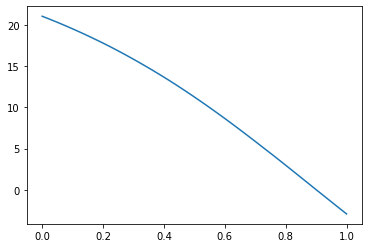

NuWave(
  (input_projection): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (low_projection): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (diffusion_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=128, out_features=512, bias=True)
    (projection2): Linear(in_features=512, out_features=512, bias=True)
  )
  (residual_layers): ModuleList(
    (0): ResidualBlock(
      (dilated_conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (diffusion_projection): Linear(in_features=512, out_features=64, bias=True)
      (output_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (low_projection): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): ResidualBlock(
      (dilated_conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (diffusion_projection): Linear(in_features=512, out_features=64, bias=True)
      (output_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  

In [39]:
T = 50

state_dict = torch.load(checkpoint, map_location='cpu')
model = UnconditionalDiffWave(T=1, cycle_length=8, dilation_base=3, layers=40)
model.load_state_dict(state_dict['ema_model'])
model = model.to(device)
model.eval()

scheduler = NoiseScheduler().to(device)
scheduler.load_state_dict(state_dict['noise_scheduler'])
t = torch.linspace(0, 1, T + 1).to(device)
# gamma = -23 + (23 + 3.6) * t
# steps = t
with torch.no_grad():
    gamma, steps = scheduler(t)
plt.plot(t.cpu().numpy(), -gamma.cpu().numpy(), label='gamma')
# plt.ylim(-5, 10)
plt.show()

# short_gamma = beta2gamma(torch.tensor(
# [1e-6, 2e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.9], device=device))

# t = (gamma[:, None] - short_gamma).abs().argmin(0) / (T + 1)
# t = torch.cat([t.new_zeros(1), t], 0)
# print(t)
# with torch.no_grad():
#     gamma, steps = scheduler(t)
state_dict = torch.load(nuwave_checkpoint, map_location='cpu')
state_dict = dict((x[6:], y) for x, y in state_dict.items() if x.startswith('model.'))

nuwave = NuWave()
nuwave.load_state_dict(state_dict)
nuwave = nuwave.to(device)
nuwave.eval()

torch.Size([96000])


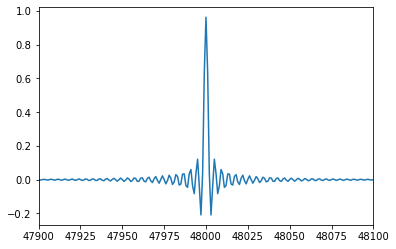

In [54]:
y, sr = torchaudio.load(test_file)

# y = torchaudio.functional.highpass_biquad(y, sr, 20, Q=0.1)

y = y.to(device).mean(0)
y = y[:y.numel() // q * q]

# decimater=kazane.Decimate(**kwargs).to(device)
decimater = STFTDecimate(q).to(device)
upsampler=kazane.Upsample(**kwargs).to(device)
linear_upsampler = torch.nn.Upsample(scale_factor=q, mode='linear', align_corners=False)

# print(decimater.kernel.size(), upsampler.kernel.size())

impulse=torch.zeros(sr, device = device)
impulse[sr // 2]=1
upsampled_impulse=upsampler(impulse.view(1, 1, -1)).squeeze()
print(upsampled_impulse.shape)

plt.plot(upsampled_impulse.cpu().numpy())
plt.xlim(sr // 2 * q - 100, sr // 2 * q + 100)
plt.show()

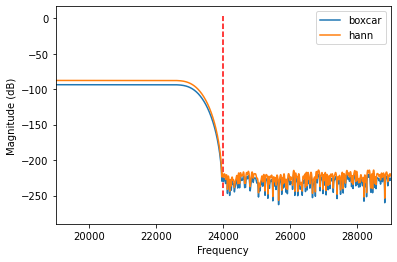

In [55]:
plt.magnitude_spectrum(upsampled_impulse.cpu().numpy(), Fs=sr * q, scale='dB', window=boxcar(upsampled_impulse.shape[0]), label='boxcar')
plt.magnitude_spectrum(upsampled_impulse.cpu().numpy(), Fs=sr * q, scale='dB', label='hann')
plt.legend()
# plt.ylim(-200, -60)
plt.xlim(sr / 2 - 5000, sr / 2 + 5000)
plt.vlines(sr/2, -250, 3, colors='r', linestyles='dashed')
plt.show()

torch.Size([2049]) torch.Size([1025])


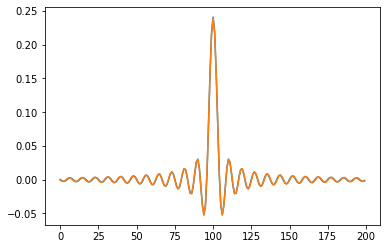

In [7]:
sinc_kernel = decimater.kernel.squeeze()
double_sinc_kernel = fft_conv1d(sinc_kernel.view(1, 1, -1), sinc_kernel.view(1, 1, -1), padding=sinc_kernel.shape[0] - 1).squeeze()
print(double_sinc_kernel.shape, sinc_kernel.shape)

plt.plot(sinc_kernel.cpu().numpy()[sinc_kernel.size(0) // 2 - 100:sinc_kernel.size(0) // 2 + 100])
plt.plot(double_sinc_kernel.cpu().numpy()[double_sinc_kernel.size(0) // 2 - 100:double_sinc_kernel.size(0) // 2 + 100])
plt.show()

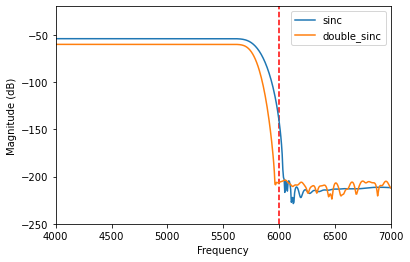

In [8]:
plt.magnitude_spectrum(sinc_kernel.cpu().numpy(), pad_to=8192, Fs=sr, scale='dB', label='sinc')
plt.magnitude_spectrum(double_sinc_kernel.cpu().numpy(), pad_to=8192, Fs=sr, scale='dB', label='double_sinc')
plt.legend()
plt.ylim(-250, -20)
plt.xlim(sr / 2 / q - 2000, sr / 2 / q + 1000)
plt.vlines(sr/2 / q, -250, 3, colors='r', linestyles='dashed')
plt.show()

torch.Size([311446]) torch.Size([311446])


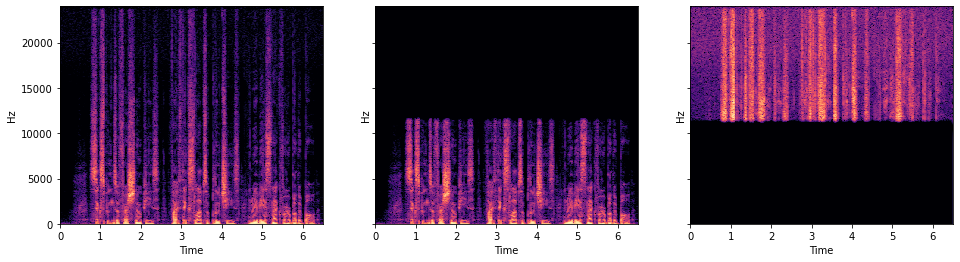

In [56]:
y_hat = upsampler(decimater(y)).squeeze()
diff = y_hat - y
print(y_hat.shape, y.shape)


fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16, 4))
img = display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[0])
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_hat.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[1])
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(diff.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[2])
plt.show()

In [57]:
y_recon = infer(y_hat, gamma,
degradation_func=amp.autocast()(lambda x: upsampler(decimater(x))),
inference_func=amp.autocast()(lambda x, t: model(x, steps[t:t+1])))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.43it/s]


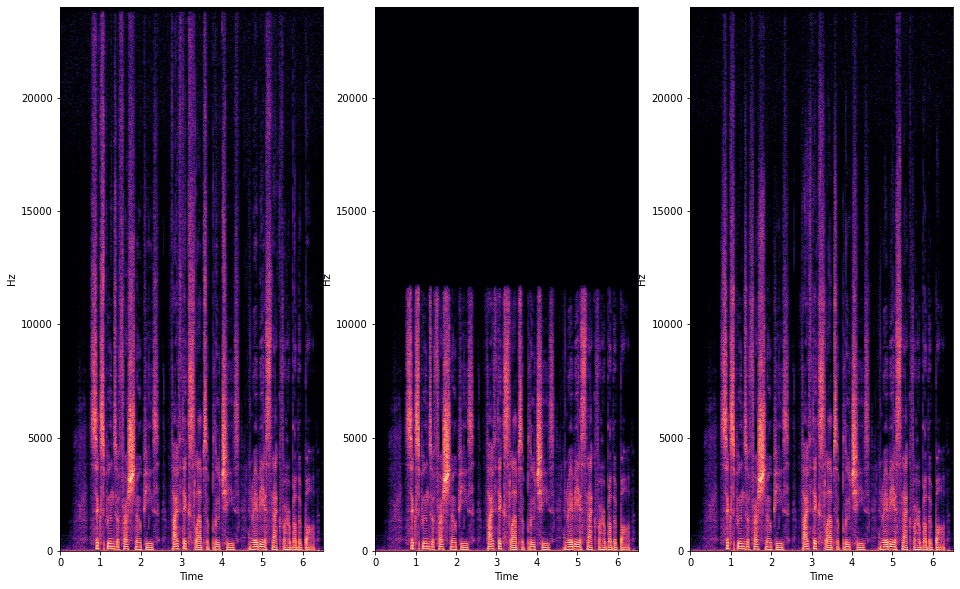

tensor(0.7081, device='cuda:0')


In [58]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(16, 10))
img = display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[0])
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_hat.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                         ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[1])
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_recon.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                         ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[2])
plt.show()

print(lsd(y_recon, y))

In [45]:
ipd.Audio(y.cpu().numpy(), rate=sr)

In [60]:
ipd.Audio(y_hat.cpu().numpy(), rate=sr)

In [59]:
ipd.Audio(y_recon.cpu().numpy(), rate=sr)

In [62]:
test_root = '/home/ycy/data-disk/Datasets/VCTK-Corpus-0.92/wav48_silence_trimmed/test'
test_files = list(Path(test_root).glob('*/*.wav'))

degradation_func = lambda x: upsampler(decimater(x))
lsd_scores = []


pbar = tqdm(test_files)
for filename in pbar:
    y, sr = torchaudio.load(filename)
    y = y.to(device).mean(0)
    y = y[:y.numel() // q * q]
    y_hat = degradation_func(y)
    y_recon = infer(y_hat, gamma, 
                    degradation_func=amp.autocast()(degradation_func),
                    inference_func=amp.autocast()(lambda x, t: model(x, steps[t:t+1])), 
                    verbose=False)
#     y_hat = linear_upsampler(decimater(y).view(1, 1, -1)).squeeze()
#     y_recon = nuwave_infer(y_hat, gamma, nuwave, verbose=False)
    
    lsd_scores.append(lsd(y_recon, y).item())
    pbar.set_postfix(lsd=lsd_scores[-1])
    # print(lsd_scores[-1])

print(np.mean(lsd_scores))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2937/2937 [3:39:55<00:00,  4.49s/it, lsd=0.674]

0.687091395974281


|       | T = 50 | T = 200 | NUWave, T = 50 | T = 7 (fast) |
|-------|--------------------|--------------------|--------------------|--------------------|
| q = 2 | 0.6896870873353496 |                    | 0.8730249699987763 |
| q = 3 | 0.8468467378275387 |                    | 1.0062805356766684 | 1.1992029415371874 |
| q = 4 | 0.9464702467387495 | 0.8561655351975194 |                    |

## STFT LowPass
|       |       T = 50       |   NUWave, T = 50   |
|-------|--------------------|--------------------|
| q = 2 | 0.687091395974281  | 0.856362808286474  |
| q = 3 | 0.8452057946812023 | 0.9922982593519492 | 


In [48]:
# y_recon = infer(y_hat, 
# degradation_func=lambda x: upsampler(decimater(x)),
# inference_func=lambda x, t: nuwave(x, y_hat.unsqueeze(0), gamma2as(gamma[t:t+1])[0]))
linear_y_hat = linear_upsampler(decimater(y).view(1, 1, -1)).squeeze()
y_recon = nuwave_infer(linear_y_hat, gamma, nuwave)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]


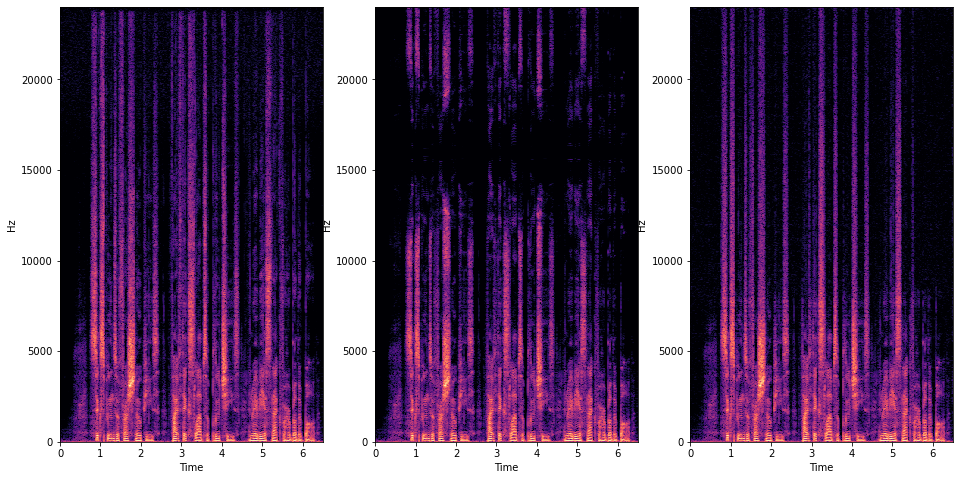

tensor(0.8763, device='cuda:0')


In [50]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(16, 8))
img = display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[0])
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(linear_y_hat.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                         ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[1])
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_recon.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                         ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[2])
plt.show()

print(lsd(y_recon, y))

# Speaker Embedding

In [9]:
kwargs['q'] = 6
downsampler = kazane.Decimate(**kwargs)
wav2mel = torch.jit.load('wav2mel.pt')
dvector = torch.jit.load('dvector-step250000.pt')

In [15]:
vctk_wav = Path('/home/ycy/data-disk/Datasets/VCTK-Corpus-0.92/wav48_silence_trimmed')

for filepath in tqdm(list(vctk_wav.glob('**/*.wav'))):
    y, sr = torchaudio.load(filepath)
    assert sr == 48000
    y = downsampler(y)
    mel = wav2mel(y, 8000)
    emb = dvector.embed_utterance(mel)
    torch.save(emb, filepath.parent / (filepath.stem + '_emb.pt'))

100%|██████████| 43873/43873 [1:01:36<00:00, 11.87it/s]
